In [1]:
%load_ext autoreload
%autoreload 2

New analysis

In [2]:
import os.path
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit
import iminuit
import seaborn as sns
import awkward as ak

from progressbar import progressbar
import re

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [3]:
season = '19'
total_info_filename = f'../data/{season}/total_info_{season}.txt'
total_info = pd.read_csv(total_info_filename, index_col=0)

In [1]:
final_states = ['$\pi^+\pi^-\pi^0$', '$2\pi^+2\pi^-$', '$\pi^+\pi^-2\pi^0$', '$2\pi^+2\pi^-\pi^0$', '$2\pi^+2\pi^-2\pi^0$', '$3\pi^+3\pi^-$',
               '$K^+K^-$', '$K_SK_L$', '$K^+K^-\pi^0$', '$K_SK^+\pi^-$', '$K_LK^-\pi^+$', '$K^+K^-\pi^+\pi^-$', '$K^+K^-\pi^0\pi^0$', '$K_LK_S\pi^+\pi^-$', 
               '$K^+K_S\pi^-\pi^0$', '$K^-K^0\pi^+\pi^0$', '$K_LK_S\pi^0\pi^0$', '$\pi^+\pi^-$', '$p\bar{p}$', '$n\bar{n}$', '$\pi^+\pi^-\eta$', 
               '$K_SK^-\pi^+$', '$K_LK^+\pi-$', '$\pi^+\pi^-3\pi^0$', '$\pi^+\pi^-4\pi^0$', '$K_SK_S\pi^+\pi^-$', '$\pi^0\gamma$', '$\eta\gamma$', 
               'wtf']

In [7]:
final_states[9]

'$K_SK^+\\pi^-$'

# Подготовить `csv` файлы

In [6]:
def ctr(df, c=0, ptot_cut=40):
    df = df.query(f'(abs(trho_n)>{c})&(abs(trho_p)>{c})&(tptot_p>{ptot_cut})&(tptot_n>{ptot_cut})&(ksdpsi<3)&(abs(tz_p)<12)&(abs(tz_n)<12)')
    return df

In [6]:
exp_files = total_info['exp_tree']

In [7]:
for i, row in total_info.iterrows():
    file = row['exp_tree'].strip()
    tr = uproot.open(file)['tr_ph']
    h = preprocess.Handler(tr, cut_z=12)
    df = ctr(h.get_good_kaons(photons=None))
    filename = f"../csv/19/{re.findall(r'(tr.+).root', file)[0]}.csv"
    df.to_csv(filename)
    total_info.at[i, 'exp_csv'] = filename[3:]
    total_info.to_csv(total_info_filename)
#     print(i, row['elabel'])

4 575_71544
5 587.5_71908
6 600_72268
7 612.5_72545
8 612.5_84504
9 625_72787
10 637.5_73035
11 641_82925
12 650_73374
13 662.5_73636
14 675_73926
15 687.5_74169
16 700_74366
17 712.5_74528
18 725_74704
19 737.5_74974
20 750_75459
21 762_75730
22 775_76033
23 787.5_76243
24 800_76450
25 812.5_76723
26 825_77131
27 837.5_77414
28 850_77631
29 862.5_77854
30 875_78066
31 887.5_78274
32 900_78506
33 912.5_78722
34 925_78931
35 936_79212
36 945_82528
37 950_79625
38 951.1_82106
39 955_81775
40 962.5_80068
41 975_80603
42 978_80506
43 987.5_81313


# Fits

In [6]:
def open_trees(row):
    df = {}
    path = {
        'exp' : row['exp_tree'] if ('exp_csv' not in row) or (row['exp_csv']==np.nan) else row['exp_csv'],
        'mc_kskl' : row['mc_tree_kskl_mcgpj'],
        'mc_kskl_uniform' : row['mc_tree_kskl_uniform']
    }
    if ('mlt_raw' in row) and not(np.isnan(row['mlt_raw'])):
        path['mlt_raw'] = f'/store17/petrov/data/kskl20/tr_ph/multi/19/tr_ph_run0{int(row["mlt_raw"])}.root'
    if ('ksklpi0_raw' in row) and not(np.isnan(row['ksklpi0_raw'])):
        path['ksklpi0_raw'] = f'/store17/petrov/data/kskl20/tr_ph/kkp0/tr_ph_run0{int(row["ksklpi0_raw"])}.root'
    tr = {i : uproot.open(path[i])['tr_ph'] if (path[i][-4:]=='root') else path[i] for i in path}
    for t in tr:
        if isinstance(tr[t], str):
            df[t] = pd.read_csv('../' + tr[t])
        else:
            h = preprocess.Handler(tr[t], cut_z=12)
            df[t] = h.get_good_kaons(photons=None)
    if 'mlt_raw' in df:
        df['mlt_raw'] = df['mlt_raw'].query('finalstate_id!=8') #drop kskl from multihadrons
    return df

In [7]:
def get_exp_lum(df):
    """
    Получить светимость и ошибку, `df` - экспериментальные данные
    """
    dd = df.groupby('runnum').agg({'ebeam': 'first', 'lumoff': 'first', 'lumofferr': 'first'})
    dd['lumerrsq'] = dd['lumofferr']**2
    return {'lum': dd['lumoff'].sum(), 'lum_err': np.sqrt(dd['lumerrsq'].sum())}

def results_to_series(row, fit_exp, fit_mc, lum_dict, fit_range, trigs):
    """
    Преобразовать результат в строку
    """
    result = {}
    result['n_sig'] = fit_exp.m.values['n_sig']
    result['n_bkg'] = fit_exp.m.values['n_bkg']
    result['n_mc'] = fit_mc.m.values['n_sig']
    result['n_sig_err'] = fit_exp.m.errors['n_sig']
    result['n_bkg_err'] = fit_exp.m.errors['n_bkg']
    result['n_mc_err'] = fit_mc.m.errors['n_sig']
    result['x1_min'], result['x1_max'] = fit_range
    result['lum'], result['lum_err'] = lum_dict['lum'], lum_dict['lum_err']
    result['eff_trig'], result['eff_trig_err'] = trigs
    return pd.Series(result, name=row['elabel'])

In [8]:
def change_parameters(f, fit_range0, fit_range1):
    """
    изменить коэффициенты фонового полинома для другого диапазона фитирования
    """
    pars = f.get_params()
    b, c = pars['b'], pars['c']
    m0, m1 = (fit_range0[0] + fit_range0[1])/2, (fit_range1[0] + fit_range1[1])/2
    w0, w1 = (fit_range0[1] - fit_range0[0]), (fit_range1[1] - fit_range1[0])
    norm = 1 + b*2*(m1 - m0)/w0 + c*( ((w1/w0)**2)/2 + 6*((m1 - m0)/w0)**2 - 1/2 )
    b1 = b*(w1/w0) + 6*c*(w1/w0)*(m1 - m0)/w0
    c1 = c*(w1/w0)**2
    return b1/norm, c1/norm

In [9]:
it = total_info.iterrows()

In [10]:
df_fit_results = pd.read_csv(f'../data/{season}/results/new_method/signal.csv', index_col=0) \
    if os.path.isfile(f'../data/{season}/results/new_method/signal.csv') else pd.DataFrame()

In [15]:
df_fit_results.columns

Index(['n_bkg', 'n_bkg_err', 'n_mc', 'n_mc_err', 'n_sig', 'n_sig_err',
       'x1_max', 'x1_min', 'lum', 'lum_err', 'eff_trig', 'eff_trig_err', 'mu',
       's', 'c', 'N', 'mu_err', 's_err', 'c_err', 'N_err', 'eff0', 'eff0_err',
       'rad'],
      dtype='object')

In [43]:
# %ls /store17/petrov/data/kskl20/tr_ph/

In [42]:
idx, row = next(it)
row

elabel                                                          825_77131
emeas                                                          824.412415
exp_tree                root://sl10cmd//scan2019/scan2019_tr_ph_fc_e82...
lum_exp                                                           1510.37
lum_exp_err                                                       2.79147
mc_raw_kskl_mcgpj       /store17/petrov/data/kskl20/raw/19/kskl_825_77...
mc_tree_kskl_mcgpj      /store17/petrov/data/kskl20/tr_ph/19/tr_ph_ksk...
mc_tree_kskl_uniform    /store17/petrov/data/kskl_uniform_individual/1...
mlt_raw                                                           53448.0
ksklpi0_raw                                                       45789.0
exp_csv                                       csv/19/tr_ph_fc_e825_v8.csv
Name: 26, dtype: object

In [12]:
df = open_trees(row)
df.keys()

dict_keys(['exp', 'mc_kskl', 'mc_kskl_uniform', 'mlt_raw'])

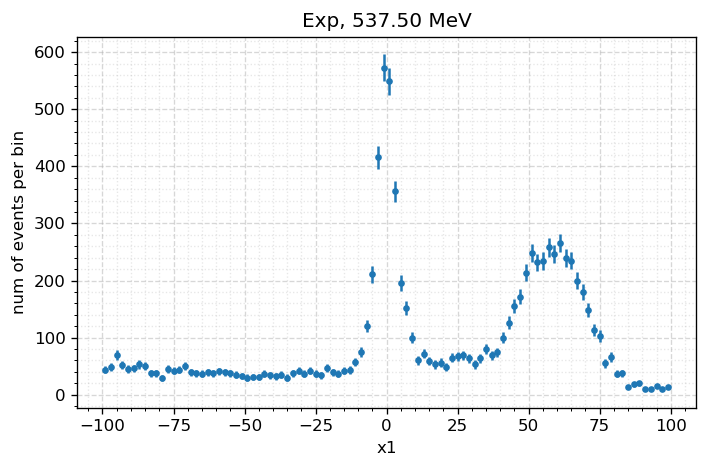

In [90]:
pys.hep_histo(df['exp'].x1, range=(-100, 100), bins=100);
pys.my_style(f'Exp, {df["exp"].ebeam.mean():.2f} MeV', 'x1', 'num of events per bin');

In [763]:
fit_range_bkg = (-20, 20)
fit2poly = pyfit.FitPoly2(fit_range_bkg)

In [764]:
f = pyfit.Fitter(df['mlt_raw'].x1, fit2poly, dict(n_sig=0, m=0, sL=1, sR=1, aL=1, aR=1, n_bkg=580, b=1, c=0),
            fit_range=fit_range_bkg, lims=dict(n_sig=(0,0), m=(0, 0), sL=(1,1), sR=(1, 1), 
            aL=(1,1), aR=(1,1), n_bkg=(0, None), b=(None, None), c=(None, None)) )
f.fit()

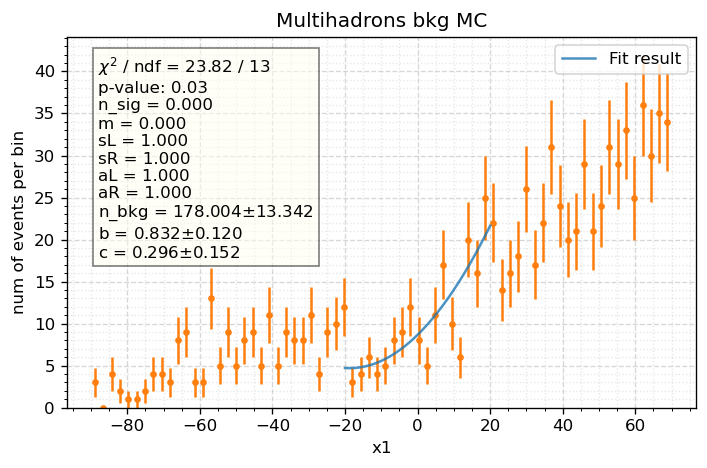

In [765]:
f.plot((-90, 70), bins=70, title='Multihadrons bkg MC', xtitle='x1', ytitle='num of events per bin');

In [766]:
fit_range = (-20, 15)
npars = change_parameters(f, fit_range_bkg, fit_range)

In [767]:
fit2poly = pyfit.FitPoly2(fit_range)

In [768]:
fmc = pyfit.Fitter(df['mc_kskl'].x1, fit2poly, dict(n_sig=100, m=0, sL=1, sR=1, aL=1, aR=1, n_bkg=0, b=0, c=0),
            fit_range=fit_range, lims=f.get_limits(n_sigmas=0, include=['b', 'c'], 
            my_lims=dict(n_sig=(0, None), m=(-20, 20), sL=(0.1, None), sR=(0.1, None), aL=(0, None), aR=(0, None), n_bkg=(0, 0))) )
fmc.fit()

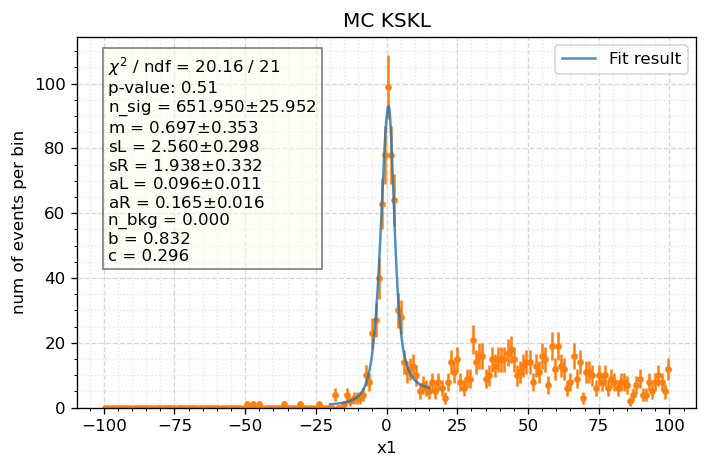

In [769]:
hist_rng, bins = (-100, 100), 180
fmc.plot(hist_rng, bins=bins, title='MC KSKL', xtitle='x1', ytitle='num of events per bin');

осознать форму сигнала - поближе к $\phi$ мезону

In [770]:
lims_mc = fmc.get_limits(n_sigmas=5, include=['sR', 'sL', 'aL', 'aR', 'm'])
lims_mc['n_bkg'] = (0, None)
lims_mc['b'] = (npars[0], npars[0])
lims_mc['c'] = (npars[1], npars[1])

In [771]:
pars_mc = fmc.get_params()
pars_mc['n_bkg'] = 100

In [772]:
f2 = pyfit.Fitter(df['exp'].x1, fit2poly, pars_mc,#dict(n_sig=100, m=0, sL=1, sR=1, aL=1, aR=1, n_bkg=100, b=1, c=0),
            fit_range=fit_range, lims=lims_mc, sigmas=fmc.get_sigmas(exclude=['n_sig', 'n_bkg',  'b', 'c', 'm']) )
f2.fit()

In [773]:
w0 = f2.m.values['n_sig']/len(df['mc_kskl'].query(f'x1>{fit_range[0]}&x1<{fit_range[1]}').x1)
processes = list(df['mlt_raw'].finalstate_id.value_counts().sort_values(ascending=True).index)

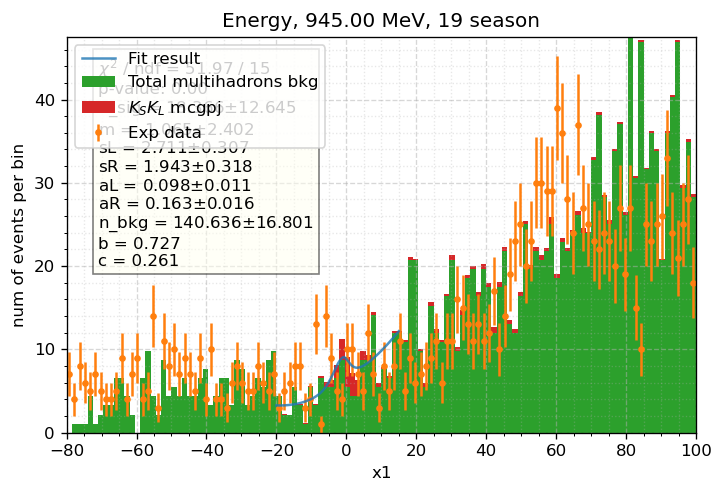

In [774]:
hist_rng, bins = (-80, 100), 120
f2.plot(hist_rng, bins=bins, xtitle='x1', ytitle='num of events per bin', label='Exp data')
bkg_dat = df['mlt_raw'].x1
bkg_dat_kskl = df['mc_kskl'].x1

d1 = plt.hist(bkg_dat, range=hist_rng, bins=bins, label='Total multihadrons bkg',
         weights=np.ones_like(bkg_dat)*(f2.m.values['n_bkg']/len(bkg_dat.loc[(bkg_dat<f2.fit_range[1])&(bkg_dat>f2.fit_range[0])])))
d2 = plt.hist(df['mc_kskl'].x1, bins=bins, range=hist_rng, bottom=d1[0], label='$K_SK_L$ mcgpj', 
         weights=np.ones_like(df['mc_kskl'].x1)*w0)
# plt.hist(df['ksklpi0_raw'].x1, bins=bins, range=hist_rng, weights=np.ones_like(df['ksklpi0_raw'].x1)*0.03, bottom=d2[0]+d1[0])
plt.title(f'Energy, {df["exp"].ebeam.mean():.2f} MeV, 19 season')
plt.legend();
plt.xlim(hist_rng);
# plt.savefig(f'../notebooks/images/13fits/{season}_{df["exp"].ebeam.mean():.2f}.png')

In [775]:
def trig_eff(df_exp):
    df = df_exp.query('abs(x1)<10').groupby('trigbits').agg(nbits=('entry', 'count')).rename({1: 'T', 2: 'C', 3: 'TC'})
    if not('T' in df.index):
        df.loc['T', 'nbits'] = 0
    if not('C' in df.index):
        df.loc['C', 'nbits'] = 0
    if not('TC' in df.index):
        df.loc['TC', 'nbits'] = 0
    T = df.at['T', 'nbits'] + df.at['TC', 'nbits']
    C = df.at['C', 'nbits'] + df.at['TC', 'nbits']
    TC = df.at['TC', 'nbits']
    if 0 in df.index:
        print('Warn: 0 in index')
    eff_T = (TC + 1)/(C + 2)
    eff_C = (TC + 1)/(T + 2)
    eff_T_err = np.sqrt( (TC+1)*(TC+2)/(C+2)/(C+3) - ((TC+1)/(C+2))**2 )
    eff_C_err = np.sqrt( (TC+1)*(TC+2)/(T+2)/(T+3) - ((TC+1)/(T+2))**2 )

    eff = 1 - (1 - eff_T)*(1 - eff_C)
    eff_err  = np.sqrt( (eff_T_err*(1-eff_C))**2 + (eff_C_err*(1-eff_T))**2 )
    return (eff, eff_err)

In [776]:
trigs = trig_eff(df['exp'])

In [777]:
lum_dict = get_exp_lum(df['exp'])
result_row = results_to_series(row, f2, fmc, lum_dict, fit_range, trigs)
if len(df_fit_results.index.intersection([result_row.name]))>0:
    df_fit_results = df_fit_results.drop([result_row.name])
df_fit_results = df_fit_results.append(result_row)
df_fit_results

,n_bkg,n_bkg_err,n_mc,n_mc_err,n_sig,n_sig_err,x1_max,x1_min,lum,lum_err,eff_trig,eff_trig_err
537.5_70914,1151.764514,45.408962,2953.999677,54.978178,2837.272156,62.496078,20.0,-60.0,1229.268367,1.828896,0.996933,0.000567
550_70260,1392.987946,47.611800,2642.045398,52.099365,1996.185444,53.574857,20.0,-60.0,1434.314148,2.020221,0.996711,0.000681
575_71544,1228.996666,42.081481,2358.014922,48.835649,702.042304,35.267940,20.0,-60.0,1058.449522,1.811253,0.995927,0.000809
587.5_71908,1455.159517,44.693796,2217.912875,47.093800,507.930598,32.410769,20.0,-60.0,1169.377513,1.944858,0.997702,0.000526
600_72268,1352.830561,43.561138,2051.075357,45.289630,399.156529,30.716397,20.0,-60.0,1165.508851,1.981560,0.998439,0.000416
612.5_72545,1315.114592,42.543916,1980.051457,44.498345,343.875530,28.966381,20.0,-60.0,1177.838452,2.034182,0.997069,0.000733
625_72787,1171.406492,40.558008,1856.983583,43.092543,273.597210,27.340868,20.0,-60.0,1093.271575,1.997800,0.998251,0.000504
637.5_73035,1075.596667,37.845587,1741.919800,41.735354,156.489784,22.668385,20.0,-60.0,1021.923961,1.970024,0.996658,0.000946
641_82925,5915.937405,94.110067,1696.945451,41.193338,1104.900498,63.839774,20.0,-60.0,6272.352874,4.909128,0.995229,0.000527
650_73374,809.364058,30.309218,1619.813249,35.432234,103.661471,21.320598,20.0,-40.0,953.083673,1.941545,0.997887,0.000904


In [53]:
# df_fit_results.to_csv(f'../data/{season}/results/new_method/signal.csv')

____

## Uniform

In [13]:
def process_uniform(row, df, fit_range, bins=80):
    df_uni = df['mc_kskl_uniform']
    df_uni['passed'] = (df['mc_kskl_uniform']['x1'] > fit_range[0]) & (df['mc_kskl_uniform']['x1'] < fit_range[1])
    
    uniform_path = row['mc_tree_kskl_uniform']
    tr_uni = uproot.open(uniform_path)['tr_ph']
    df_ens = ak.to_pandas( tr_uni.arrays(['simtype', 'simmom', 'simorig']) ).query('simtype==22').\
    groupby(['entry']).agg('sum').drop(['simtype', 'simorig'], axis=1)
    print('Len uniform mc:', len(df_ens))
    df_ens = df_ens.join(df['mc_kskl_uniform'][['passed']])
    df_ens = df_ens.fillna(False)
    
    dat0, bins = np.histogram(df_ens.simmom, bins=bins, range=(df_ens.simmom.min(), df_ens.simmom.max()))
    dat1, bins = np.histogram(df_ens.query('passed==True').simmom, bins=bins, range=(df_ens.simmom.min(), df_ens.simmom.max()))
    
    values = (dat1+1)/(dat0+2)
    errors = np.sqrt( (dat1+1)*(dat1+2)/(dat0+2)/(dat0+3) - ((dat1+1)/(dat0+2))**2 )
    return (values, errors, (bins[:-1]+bins[1:])/2)

In [14]:
from pylib.regeff import RegEff

In [15]:
it = total_info.iterrows()

In [21]:
idx, row = next(it)
row

elabel                                                        587.5_71908
emeas                                                          587.726379
exp_tree                root://sl10cmd//scan2019/scan2019_tr_ph_fc_e58...
lum_exp                                                           1178.63
lum_exp_err                                                       1.76558
mc_raw_kskl_mcgpj       /store17/petrov/data/kskl20/raw/19/kskl_587.5_...
mc_tree_kskl_mcgpj      /store17/petrov/data/kskl20/tr_ph/19/tr_ph_ksk...
mc_tree_kskl_uniform    /store17/petrov/data/kskl_uniform_individual/1...
mlt_raw                                                           45606.0
ksklpi0_raw                                                       45770.0
exp_csv                                     csv/19/tr_ph_fc_e587.5_v8.csv
Name: 5, dtype: object

Len uniform mc: 20000


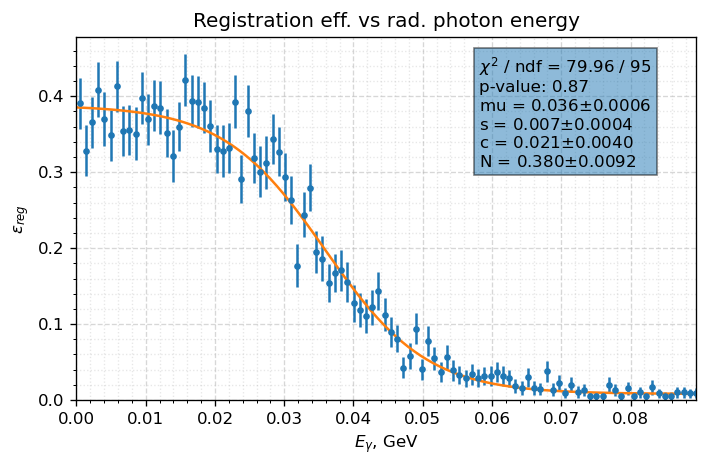

In [24]:
df = open_trees(row)
info = df_fit_results.loc[row['elabel']]

dat = process_uniform(row, df, (info.x1_min, info.x1_max), 100)
fit_res = RegEff.fit_data(dat[0], dat[1], dat[2], mu0=0.05, s0=1/90, name=row['elabel'])
plt.tight_layout()
# plt.savefig(f'./images/effreg_{row["elabel"]}.png')

In [222]:
if len(fit_res.columns.intersection(df_fit_results.columns)) == len(fit_res.columns):
    df_fit_results.loc[row['elabel'], fit_res.columns] = fit_res.iloc[0]
else:
    df_fit_results = pd.concat([df_fit_results, fit_res], axis=1)

In [223]:
df_fit_results.iloc[30:40]

,n_bkg,n_bkg_err,n_mc,n_mc_err,n_sig,n_sig_err,x1_max,x1_min,lum,lum_err,...,mu,s,c,N,mu_err,s_err,c_err,N_err,eff0,eff0_err
912.5_78722,129.989936,1.969860,454.064351,16.903661,0.000003,0.940918,15.0,-40.0,1011.097441,2.793420,...,0.059978,0.032438,0.013682,0.424415,0.006696,0.002607,0.002509,0.034772,0.372506,0.034503
925_78931,101.068910,12.327459,519.001809,22.781645,9.916122,7.769031,15.0,-40.0,1048.702367,2.882346,...,0.066796,0.029073,0.015932,0.402883,0.004931,0.002536,0.002484,0.025476,0.372506,0.023601
936_79212,203.633976,17.134679,530.985888,23.042820,29.374893,10.929245,15.0,-40.0,1874.286410,3.902221,...,0.075953,0.029688,0.017873,0.339541,0.005285,0.002518,0.002846,0.021565,0.321207,0.020549
945_82528,140.636263,16.801251,651.949842,25.952346,18.365950,12.645123,15.0,-20.0,2295.059648,4.360203,...,0.070840,0.031859,0.015928,0.371187,0.006344,0.002822,0.002716,0.027513,0.340850,0.026419


## Radcors

In [48]:
info = total_info.set_index('elabel')[['emeas']].join(df_fit_results, how='right')

In [25]:
df_fit = pd.read_csv('../data/other/kskl_cs.csv', index_col=0)

In [22]:
from pylib.radcors import RadCor
from pylib.regeff import RegEff

In [50]:
r = RadCor(df_fit.emeas*0.5e3, df_fit.cs_born)

In [51]:
for index, j in info.iterrows():
    rad, rad_err = r.F_Radcor(j['emeas'], j[['mu', 's', 'c', 'N']])/RegEff.sigFunc(0, *j[['mu', 's', 'c', 'N']])
    df_fit_results.at[index, 'rad'] = rad

In [27]:
df_fit_results.head()

,n_bkg,n_bkg_err,n_mc,n_mc_err,n_sig,n_sig_err,x1_max,x1_min,lum,lum_err,...,s,c,N,mu_err,s_err,c_err,N_err,eff0,eff0_err,rad
537.5_70914,1151.764514,45.408962,2953.999677,54.978178,2837.272156,62.496078,20.0,-60.0,1229.268367,1.828896,...,0.003262,0.020239,0.361100,0.000261,0.000199,0.005901,0.007220,0.367850,0.009333,0.910992
550_70260,1392.987946,47.611800,2642.045398,52.099365,1996.185444,53.574857,20.0,-60.0,1434.314148,2.020221,...,0.004409,0.014785,0.344124,0.000382,0.000273,0.004884,0.007706,0.348132,0.009194,0.908496
575_71544,1228.996666,42.081481,2358.014922,48.835649,702.042304,35.267940,20.0,-60.0,1058.449522,1.811253,...,0.006202,0.009599,0.364095,0.000522,0.000351,0.003296,0.007907,0.366088,0.008811,0.913986
587.5_71908,1455.159517,44.693796,2217.912875,47.093800,507.930598,32.410769,20.0,-60.0,1169.377513,1.944858,...,0.007164,0.018673,0.379245,0.000631,0.000428,0.003690,0.008945,0.383852,0.009929,0.934711
600_72268,1352.830561,43.561138,2051.075357,45.289630,399.156529,30.716397,20.0,-60.0,1165.508851,1.981560,...,0.009432,0.011582,0.387947,0.000898,0.000555,0.003349,0.010940,0.385873,0.011254,0.923703


## Lum

стоит всё-таки использовать светимость из официальных файлов

## DC corrections

пока что использую поправки из прошлого метода

In [11]:
dc = pd.read_csv('../data/19/results/new_method/dccorr.csv', index_col='elabel')
results = df_fit_results.join(total_info.set_index('elabel')[['emeas', 'lum_exp', 'lum_exp_err']])
results.drop(['lum', 'lum_err'], axis=1, inplace=True)
results = results.join(dc)

In [12]:
results.columns

Index(['n_bkg', 'n_bkg_err', 'n_mc', 'n_mc_err', 'n_sig', 'n_sig_err',
       'x1_max', 'x1_min', 'eff_trig', 'eff_trig_err', 'mu', 's', 'c', 'N',
       'mu_err', 's_err', 'c_err', 'N_err', 'eff0', 'eff0_err', 'rad', 'emeas',
       'lum_exp', 'lum_exp_err', 'dccorr', 'dccorr_err'],
      dtype='object')

In [21]:
def get_cs(df):
    cs = df['n_sig']/df['lum_exp']/df['eff_trig']/df['eff0']/df['rad']/df['dccorr']
    cs_err = cs*df['rad']*np.sqrt( (df['n_sig_err']/df['n_sig'])**2 + (df['eff0_err']/df['eff0'])**2 )
    return (cs, cs_err)

In [22]:
results['cs'], results['cs_err'] = get_cs(results)

In [23]:
# info = total_info.set_index('elabel')[['emeas']].join(df_fit_results, how='right')

In [24]:
# info

In [25]:
df0.columns

Index(['n_sig_exp', 'm_exp', 'sL_exp', 'sR_exp', 'aL_exp', 'aR_exp', 'y0_exp',
       'dy_exp', 'n_sig_exp_err', 'm_exp_err', 'sL_exp_err', 'sR_exp_err',
       'aL_exp_err', 'aR_exp_err', 'y0_exp_err', 'dy_exp_err', 'n_sig_mc',
       'm_mc', 'sL_mc', 'sR_mc', 'aL_mc', 'aR_mc', 'n_sig_mc_err', 'm_mc_err',
       'sL_mc_err', 'sR_mc_err', 'aL_mc_err', 'aR_mc_err', 'emeas',
       'n_bkg_exp', 'n_bkg_exp_err', 'mu', 's', 'c', 'N', 'mu_err', 's_err',
       'c_err', 'N_err', 'eff0', 'eff0_err', 'TF', 'CF', 'TC', 'effT', 'effC',
       'effT_err', 'effC_err', 'eff_trig', 'eff_trig_err', 'lum', 'lum_err',
       'dccorr', 'dccorr_err', 'rad', 'rad_err', 'cs_born', 'cs_born_err',
       'season'],
      dtype='object')

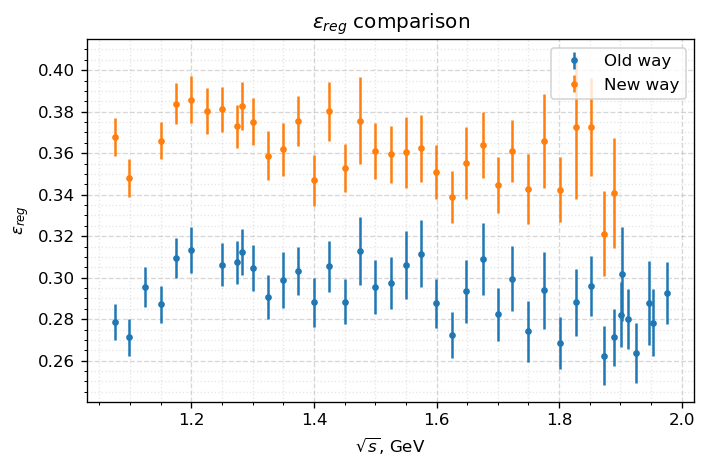

In [26]:
plt.errorbar( df0.emeas*2e-3, df0.eff0, yerr=df0.eff0_err, fmt='.', label='Old way')
plt.errorbar( results.emeas*2e-3, results.eff0, yerr=results.eff0_err, fmt='.', label='New way')
pys.my_style('$\\varepsilon_{reg}$ comparison', '$\\sqrt{s}$, GeV', '$\\varepsilon_{reg}$', legend=True)
# plt.savefig('./images/eff_reg_comparison.png')

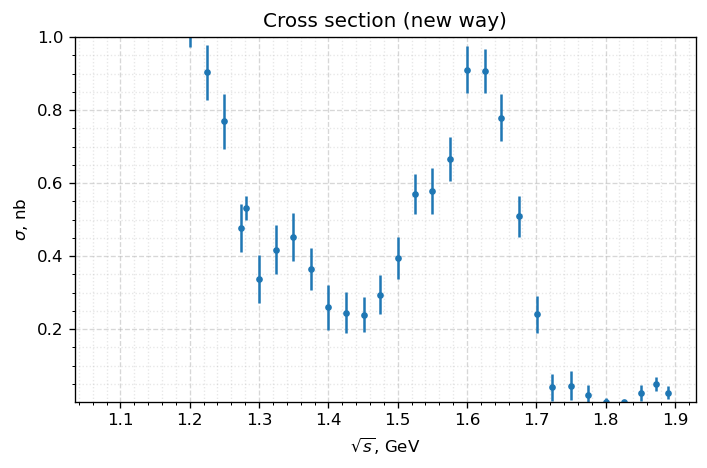

In [48]:
plt.errorbar( results.emeas*2e-3, results.cs, yerr=results.cs_err, fmt='.')
# plt.yscale('log')
pys.my_style('Cross section (new way)', '$\\sqrt{s}$, GeV', '$\\sigma$, nb', ylim=(1e-3, 1))
# plt.savefig('./images/cs_new_way.png')

In [30]:
def calc_cs_born(df):
    cs_born = df['n_sig_exp']/(df['lum']*df['eff0']*df['eff_trig']*df['rad']*df['dccorr'])
    cs_born_err = cs_born*df['rad']*np.sqrt( (df['n_sig_exp_err']/df['n_sig_exp'])**2 +
        + (df['eff0_err']/df['eff0'])**2 ) # + (df['lum_err']/df['lum'])**2  + (df['eff_trig_err']/df['eff_trig'])**2 + 
                                           #(df['dccorr_err']/df['dccorr'])**2) #не делю на рад.поправку
    return (cs_born, cs_born_err)
def get_cs(season, dropna=False):
    df_signal = pd.read_csv(f'../data/{season}/results/signal.csv', index_col=0)
    df_reg_eff = pd.read_csv(f'../data/{season}/results/reg_eff.csv', index_col=0)
    df_triggers = pd.read_csv(f'../data/{season}/results/triggers.csv', index_col=0)
    df_lum = pd.read_csv(f'/storeA/ryzhenenkov/lum20{season}.dat', sep='\t', names=['energy', 'lum', 'lum_err'], index_col='energy')
    df_dc = pd.read_csv(f'../data/{season}/results/dc_n2.csv', index_col=0) \
        if os.path.isfile(f'../data/{season}/results/dc_n2.csv') else pd.DataFrame({'dccorr': 1, 'dccorr_err': 0}, index=df_signal.index)
    df_rads = pd.read_csv(f'../data/{season}/results/radcors_n.csv', index_col=0) \
        if os.path.isfile(f'../data/{season}/results/radcors_n.csv') else pd.DataFrame({'rad': 1, 'rad_err': 0}, index=df_signal.index)
    df = pd.concat([df_signal, df_reg_eff, df_triggers, df_lum, df_dc, df_rads], axis=1)
    df.rad.fillna(1, inplace=True)
    df.rad_err.fillna(0, inplace=True)
    df['cs_born'], df['cs_born_err'] = calc_cs_born(df)
    df['season'] = season
    if dropna:
        df.dropna(inplace=True)
    return df

In [31]:
df0 = get_cs(19)
df0 = df0.drop([550.1], axis=0)
df0['elabel'] = total_info.elabel.dropna().values
df0 = df0.set_index('elabel')

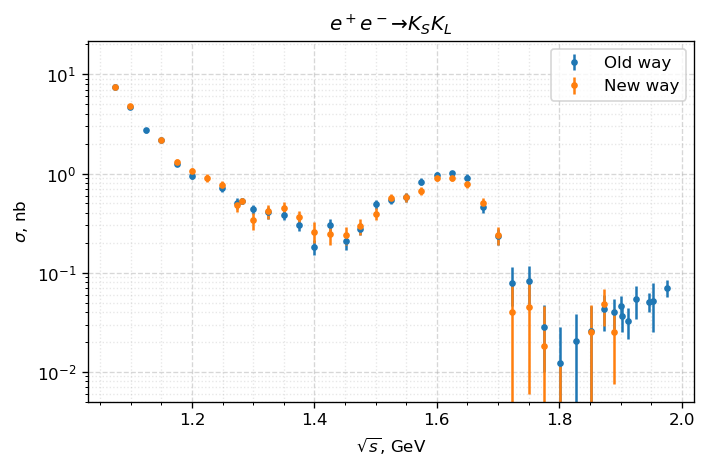

In [72]:
plt.errorbar( df0.emeas*2e-3, df0.cs_born, yerr=df0.cs_born_err, fmt='.', label='Old way')
plt.errorbar( results.emeas*2e-3, results.cs, yerr=results.cs_err, fmt='.', label='New way')
plt.yscale('log')
pys.my_style('$e^+e^- \\to K_SK_L$', '$\\sqrt{s}$, GeV', '$\\sigma$, nb', ylim=(5e-3, None), legend=True)
# plt.savefig('./images/cs_comparison.png')

## Сравнить сечения

In [33]:
df_comp = pd.DataFrame({
    'cs_old' : df0.cs_born,
    'cs_old_err' : df0.cs_born_err,
    'cs_new' : results.cs,
    'cs_new_err' : results.cs_err,
    's' : results.emeas*2e-3,
})
df_comp['diff_cs'] = (df_comp['cs_new'] - df_comp['cs_old'])

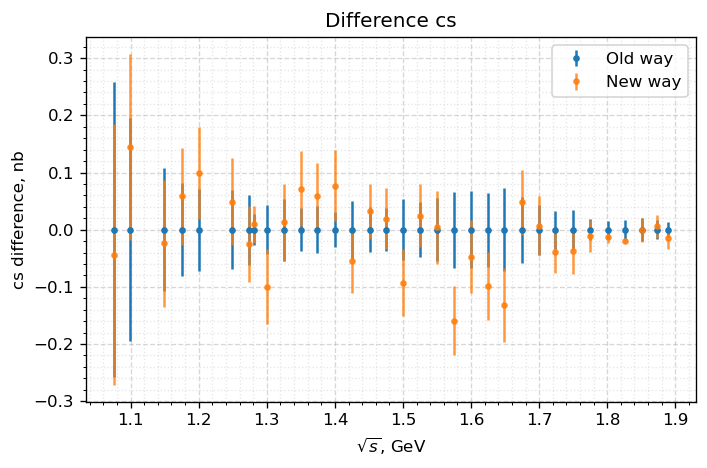

In [37]:
plt.errorbar(df_comp.s, df_comp['cs_old'] - df_comp['cs_old'], yerr=df_comp['cs_old_err'], fmt='.', label='Old way')
plt.errorbar(df_comp.s, df_comp['cs_new'] - df_comp['cs_old'], yerr=df_comp['cs_new_err'], fmt='.', label='New way', alpha=0.8) #np.sqrt( np.abs(df_comp['cs_new_err']**2 - df_comp['cs_old_err']**2))
pys.my_style('Difference cs', '$\\sqrt{s}$, GeV', 'cs difference, nb', legend=True)
# plt.savefig('./images/cs_comparison_line.png')

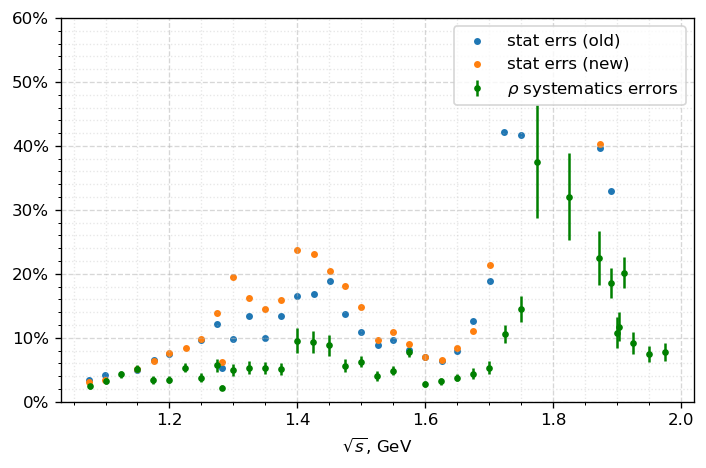

In [71]:
plt.scatter(df_comp.s, df_comp['cs_old_err']/df_comp['cs_old'], label='stat errs (old)', s=10)
plt.scatter(df_comp.s, df_comp['cs_new_err']/df_comp['cs_new'], label='stat errs (new)', s=10)
plt.errorbar(df_sys.index*2e-3, df_sys.sys_rho, yerr=df_sys.sys_rho_err, fmt='.g', label='$\\rho$ systematics errors')
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
pys.my_style('', '$\\sqrt{s}$, GeV', '', ylim=(0, 0.6), legend=True)

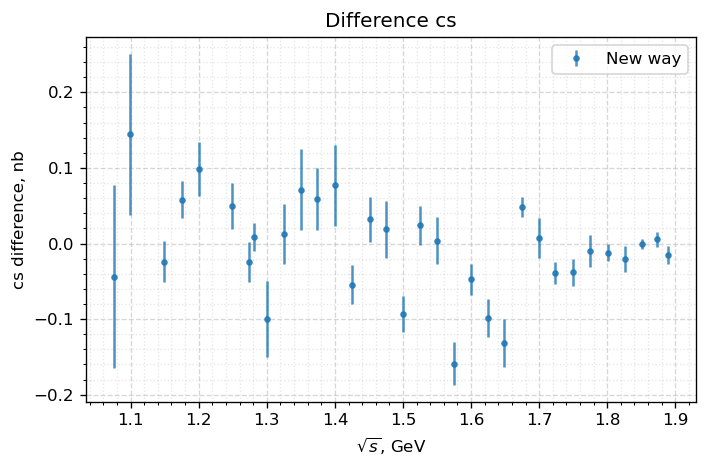

In [50]:
# plt.errorbar(df_comp.s, df_comp['cs_old'] - df_comp['cs_old'], yerr=df_comp['cs_old_err'], fmt='.', label='Old way')
plt.errorbar(df_comp.s, (df_comp['cs_new'] - df_comp['cs_old']), yerr=np.sqrt( np.abs(df_comp['cs_new_err']**2 - df_comp['cs_old_err']**2)), fmt='.', label='New way', alpha=0.8) #
pys.my_style('Difference cs', '$\\sqrt{s}$, GeV', 'cs difference, nb', legend=True)
# plt.savefig('./images/cs_comparison_line.png')

In [46]:
# plt.hist((df_comp['cs_new'] - df_comp['cs_old'])/np.sqrt( np.abs(df_comp['cs_new_err']**2 - df_comp['cs_old_err']**2)), bins=10);

In [142]:
total_info.elabel.dropna().values

array(['537.5_70914', '550_70260', '562.5_71178', '575_71544',
       '587.5_71908', '600_72268', '612.5_72545', '612.5_84504',
       '625_72787', '637.5_73035', '641_82925', '650_73374',
       '662.5_73636', '675_73926', '687.5_74169', '700_74366',
       '712.5_74528', '725_74704', '737.5_74974', '750_75459',
       '762_75730', '775_76033', '787.5_76243', '800_76450',
       '812.5_76723', '825_77131', '837.5_77414', '850_77631',
       '862.5_77854', '875_78066', '887.5_78274', '900_78506',
       '912.5_78722', '925_78931', '936_79212', '945_82528', '950_79625',
       '951.1_82106', '955_81775', '962.5_80068', '975_80603',
       '978_80506', '987.5_81313'], dtype=object)

попробовать $K_SK_S$ два $K_S$ (импульсы, энергии, коллинеарность)

In [65]:
df_sys = pd.read_csv('../data/19/results/new_method/sys_rho.csv', index_col=0).set_index('ebeam').sort_index()

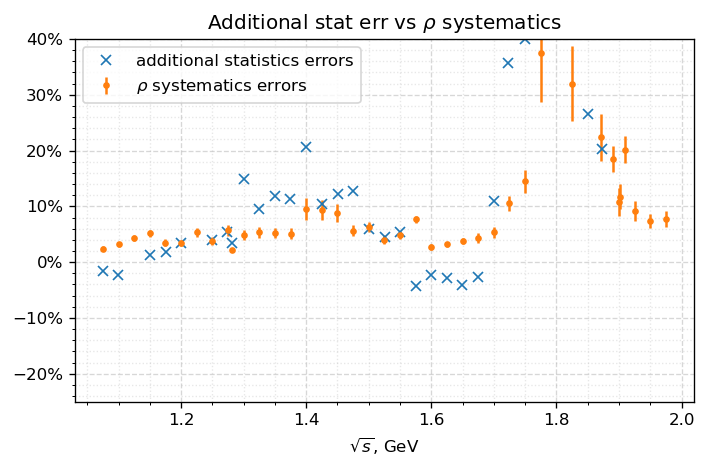

In [63]:
temp_diff = df_comp['cs_new_err']**2 - df_comp['cs_old_err']**2
plt.plot(df_comp.s, np.sign(temp_diff)*np.sqrt(np.abs(temp_diff))/df_comp['cs_new'], marker='x', lw=0, label='additional statistics errors')
plt.errorbar(df_sys.index*2e-3, df_sys.sys_rho, yerr=df_sys.sys_rho_err, fmt='.', label='$\\rho$ systematics errors')
plt.ylim(-.25, .4)

from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
pys.my_style('Additional stat err vs $\\rho$ systematics', '$\\sqrt{s}$, GeV', legend=True);
# plt.savefig('./images/statvsrho.png')